In [1]:
import os
from pathlib import Path
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches 

import geopandas as gpd
from shapely.geometry import Polygon

# for aWhere API
import requests as rq
from header import AWhereAPI
from secret_codes import *

api_key = API_KEY
api_secret = API_SECRET

warnings.simplefilter("ignore")

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
# Set variables for aWhere API call 

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": "application/json"}

agro_header = {"Authorization":  "Bearer %s" % token}

In [4]:
# Load areas of interest into gpd
# Siskiyou is area of interest, Josephine is for testing API

# Create path to home
home = str(Path.home())

# Create paths to geojsons since csvs make Jupyter crash
path_to_josephine = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "josephine.geojson")

path_to_siskiyou = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "siskiyou.geojson")

# Create dfs with 1 county (Josephine is for testing)
josephine = gpd.read_file(path_to_josephine)
siskiyou = gpd.read_file(path_to_siskiyou)

# Convert CRS
josephine = josephine.to_crs("EPSG:4236")
siskiyou = siskiyou.to_crs("EPSG:4326")

In [5]:
def create_grid(study_area_path, buffer_distance, cell_size=0.08):
    """
    """
    # Read shapefile into geodataframe
    study_area = gpd.read_file(study_area_path)

    # Project to WGS 84 Lat/Lon, EPSG 4326 if no CRS match
    if not study_area.crs == "epsg:4326":
        study_area_4326 = study_area.to_crs("epsg:4326")

    else:
        study_area_4326 = study_area

    # Create buffer around state boundary
    study_area_4326_buffer = study_area_4326.buffer(distance=buffer_distance)

    # Convert buffer from geoseries to geodataframe
    study_area_4326_buffer_gdf = gpd.GeoDataFrame(
        study_area_4326_buffer, crs="epsg:4326"
    )

    # Rename geometry column in buffer
    study_area_4326_buffer_gdf.rename(columns={0: "geometry"}, inplace=True)

    # Get extent of buffered boundary
    longitude_min = study_area_4326_buffer_gdf.bounds.minx[0]
    latitude_min = study_area_4326_buffer_gdf.bounds.miny[0]
    longitude_max = study_area_4326_buffer_gdf.bounds.maxx[0]
    latitude_max = study_area_4326_buffer_gdf.bounds.maxy[0]

    # Create lists for lat/lon extents
    longitude_vals = np.arange(longitude_min, longitude_max, cell_size)
    latitude_vals = np.arange(latitude_min, latitude_max, cell_size)

    # Create grid of polygons based on longitude and latitude ranges
    grid_polys_list = [
        Polygon(
            [
                (longitude, latitude),
                (longitude + cell_size, latitude),
                (longitude + cell_size, latitude + cell_size),
                (longitude, latitude + cell_size),
            ]
        )
        for longitude in longitude_vals
        for latitude in latitude_vals
    ]

    # Create geodataframe from grid polygons
    grid_polys_gdf = gpd.GeoDataFrame(crs=4326, geometry=grid_polys_list)

    # Narrow grid cells to those within the buffered boundary
    study_area_grid_4326 = gpd.sjoin(
        grid_polys_gdf, study_area_4326_buffer_gdf, op="within"
    )

    # Drop unnecessary colum
    study_area_grid_4326.drop(columns="index_right", inplace=True)

    # Return gridded geodataframe
    return study_area_grid_4326, study_area_4326

In [6]:
def call_api(lat, lon, start_d, end_d, norms_or_values, testing=False):
    """
    Calls aWhere's API and requests agronomic norms (for a range of days
    for all years from 2006 to 2019) or agronomic values (for a range of days
    in a specific year). 
    
    Parameters
    ----------
    lat: int or float
        Number representing latitude of location to call API for. Acceptable values
        are from -90 to 90
    
    lon: int or float
        Number representing longitude of location to call API for. Acceptable values
        are from -180 to 180
    
    start_d: string
        Start of time period to collect values for. Of format "YYYY-MM-DD" 
        (for agronomic values) or "MM-DD" (for agronomic norms). If the 
        wrong format is passed ("MM-DD" for values, for example) the returned
        JSON will show an error.
    
    end_d:
        End of time period to collect values for. Of format "YYYY-MM-DD" 
        (for agronomic values) or "MM-DD" (for agronomic norms). If the 
        wrong format is passed ("MM-DD" for values, for example) the returned
        JSON will show an error.
    
    norms_or_values: string
        Format "norms" or "values". If "norms", start_d and end_d must be of 
        format "MM-DD". If "values", start_d and end_d must be of format
        "YYYY-MM-DD".
    
    testing: Boolean
        Default false. If True, returns API URL instead of JSON-like object.
        
    Returns
    -------
    ag_json: JSON-like object
        Contains full response from aWhere's API
    
    """

    # Return norms
    if norms_or_values == 'norms':

        api_call_type = "agronomicnorms"

    # Return values
    elif norms_or_values == 'values':

        api_call_type = "agronomicvalues"

    # Catch errors (forgot argument)
    else:

        raise ValueError(
            "Please specify a type of API call: \'values\' or \'norms\'")

    # URL to agricultural data (norms or values)
    ag_url = f"/v2/agronomics/locations/{lat},{lon}/{api_call_type}/{start_d},{end_d}"

    # Endpoint suffix to get all accumulations (exclude array of daily values)
    url_append = "?properties=accumulations"

    # Full URL, endpt is defined up top
    full_url = endpt + ag_url + url_append

    if testing == False:

        # Get JSON
        ag_json = rq.get(full_url, headers=agro_header).json()

        # Testing
        return ag_json

    elif testing == True:

        return full_url

In [7]:
def get_norms(in_grid_gdf, start_d, end_d, drop_null=False):
    """
    Gets agronomic norms from aWhere's API for each grid
    cell in input GeoDataFrame.
    
    Parameters
    ----------
    in_grid_gdf: Geopandas GeoDataFrame
        Contains at least 1 geometry for which to find
        agronomic norms. Ideally grid cell is 9 km by 9 km,
        the size used by aWhere to return data.
        
    start_d: string 
        Start of time period to collect values for of format "MM-DD".
    
    end_d: string 
        End of time period to collect values for of format "MM-DD".

    Returns
    -------
    out_gdf: Geopandas GeoDataFrame
        Contains original geometries and agronomic norm values for 
        specified time period.
    """
    
    all_rows = []

    # Create columns in gdf
    columns_to_add = ["avg_accum_precip",
                      "avg_accum_precip_stdev",
                      "avg_accum_pet",
                      "avg_accum_pet_stdev",
                      "avg_accum_ppet",
                      "avg_accum_ppet_stdev"]

    # Add columns to gdf and set as NaN if they do not exist
    for col in columns_to_add:
        if col not in in_grid_gdf:
            in_grid_gdf[col] = np.nan

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in in_grid_gdf.iterrows():

        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_json = call_api(lat, lon, start_d, end_d, "norms")

        # Wrap in try since some cells might be in ocean and not have values
        try:

            # Get average accumulated precip
            avg_accum_precip = ag_json.get("averageAccumulations").get(
                "precipitation").get("average")

            # Get average accumulated precip stdev
            avg_accum_precip_stdev = ag_json.get(
                "averageAccumulations").get("precipitation").get("stdDev")

            # Get average accumulated PET
            avg_accum_pet = ag_json.get(
                "averageAccumulations").get("pet").get("average")

            # Get average accumulated PET stdev
            avg_accum_pet_stdev = ag_json.get(
                "averageAccumulations").get("pet").get("stdDev")

            # Get average accumulated P/PET for time range
            avg_accum_ppet = ag_json.get(
                "averageAccumulations").get("ppet").get("average")

            # Get average accumulated P/PET stdev over time perion
            avg_accum_ppet_stdev = ag_json.get(
                "averageAccumulations").get("ppet").get("stdDev")

            year_dict = {"avg_accum_precip": avg_accum_precip,
                         "avg_accum_precip_stdev": avg_accum_precip_stdev,
                         "avg_accum_pet": avg_accum_pet,
                         "avg_accum_pet_stdev": avg_accum_pet_stdev,
                         "avg_accum_ppet": avg_accum_ppet,
                         "avg_accum_ppet_stdev": avg_accum_ppet_stdev,
                         "geometry": row.geometry}

            all_rows.append(year_dict)

        except:

            {"avg_accum_precip": np.nan,
             "avg_accum_precip_stdev": np.nan,
             "avg_accum_pet": np.nan,
             "avg_accum_pet_stdev": np.nan,
             "avg_accum_ppet": np.nan,
             "avg_accum_ppet_stdev": np.nan,
             "geometry": row.geometry}
            
            all_rows.append(year_dict)

    out_gdf = gpd.GeoDataFrame(data=all_rows, crs="EPSG:4326")

    print("Grid with agronomic values generated.")

    return out_gdf

In [8]:
def get_vals(in_grid_gdf, start_d, end_d, drop_null=False):
    """
    Gets agronomic values from aWhere's API for each grid
    cell in input GeoDataFrame.
    
    Parameters
    ----------
    in_grid_gdf: Geopandas GeoDataFrame
        Contains at least 1 geometry for which to find
        agronomic norms. Ideally grid cell is 9 km by 9 km,
        the size used by aWhere to return data.
        
    start_d: string 
        Start of time period to collect values for of format "YYYY-MM-DD".
    
    end_d: string 
        End of time period to collect values for of format "YYYY-MM-DD".

    Returns
    -------
    out_gdf: Geopandas GeoDataFrame
        Contains original geometries and agronomic values for 
        specified time period.
    """
    
    # Create list to hold dicts, 1 for each row
    all_rows = []

    # Create columns in gdf
    columns_to_add = ["accum_precip",
                      "accum_pet",
                      "ppet"]

    # Add columns to gdf and set as NaN if they do not exist
    for col in columns_to_add:
        if col not in in_grid_gdf:
            in_grid_gdf[col] = np.nan

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in in_grid_gdf.iterrows():

        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_json = call_api(lat, lon, start_d, end_d, "values")

        # Wrap in try since some cells might be in ocean and not have values
        try:

            # Get average accumulated precip
            accum_precip = ag_json.get("accumulations").get("precipitation").get("amount")

            # Get average accumulated PET
            accum_pet = ag_json.get("accumulations").get("pet").get("amount")

            # Find P/PET for time range
            accum_ppet = accum_precip / accum_pet

            # Append values to dict item for current year
            year_dict = {"accum_precip": accum_precip,
                         "accum_pet": accum_pet,
                         "accum_ppet": accum_ppet,
                         "geometry": row.geometry}
            
            # Append dict for current year to list to pass to Geopandas later
            all_rows.append(year_dict)

        except:
            
            # Append NaN to dict item for current year
            year_dict = {"accum_precip": np.nan,
                         "accum_pet": np.nan,
                         "accum_ppet": np.nan,
                         "geometry": row.geometry}
            
            # Append dict for current year to list to pass to Geopandas later
            all_rows.append(year_dict)
            
    # Create GDF with original geometries and values
    out_gdf = gpd.GeoDataFrame(data=all_rows, crs="EPSG:4326")
    
    # Print progress message
    print("Grid with agronomic values generated.")

    return out_gdf

In [9]:
def to_convex_hull(gdf):
    """
    Reads in a GeoDataFrame with a and returns a convex hull 
    over the largest contiguous areas that is less than or
    equal to a threshold value. 
    
    Parameters
    ----------
    gdf: Geopandas GeoDataFrame
        Must contain a column named "ppet_under_thresh" that 
        equals 1 for values less than or equal to the threshold
        and 0 for other values.
        
    Returns
    -------
    hull_largest_out: Geopandas GeoDataFrame
        Contains 1 feature, where geometry equals
        a convex hull.
    
    """
    
    # Drop all rows that do not meet threshold
    under_thresh_gdf = gdf[gdf.ppet_under_thresh == 1]
    
    # Dissolve polygons that meet threshold
    under_thresh_dissolve = under_thresh_gdf.dissolve(by="ppet_under_thresh")
    
    # Explode polygons so that there are unique contiguous areas
    exploded = under_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Get largest polygon
    largest = exploded[exploded.area == exploded.area.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull
    
    # Reset index so only item in gdf is in position [0]
    hull_largest_out = hull_largest.reset_index(drop=True)
    
    return hull_largest_out

In [10]:
def proportional_split(grid_gdf, hull_gdf, crs, ppet_col_name):
    """
    Reads in gridded GeoDataFrame and returns average value of numerical
    column argument. Used because convex hull may pass through cells that 
    do not meet threshold value, but the user still wishes to consider
    their proportional impact on the overall value. Proportional split
    equals the value for that cell multiplied by the % area that the
    convex hull covers.
    
    Parameters
    ----------
    grid_gdf: Geopandas GeoDataFrame
        Contains gridded cells and at least 1 column of values to
        average.
        
    hull_gdf: Geopandas GeoDataFrame
        Contains 1 feature, convex hull that intersects grid_gdf.
        
    crs: string or integer
        Coordinate reference system (CRS) EPSG identifier. Used to 
        calculate areas in user's desired CRS so that units
        may be specified.
        
    ppet_col_name: string
        Name of column to find average values for.
        
    Returns
    -------
    avg_falue: float
        Average value from proportional split for column of
        interest (parameter "ppet_col_name").
    
    
    """
    
    grid_gdf = grid_gdf.to_crs(f"EPSG:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"EPSG:{crs}")
    
    # This is a list to more easily calculate avg (using sum then len)
    interpolated_values = []
    
    # Loop thru cells in gdf
    for index, row in grid_gdf.iterrows():
        
        if row.geometry.intersects(hull_gdf.geometry[0]):
            
            # Get intersection area
            intersect_area = row.geometry.intersection(hull_gdf.geometry[0]).area
            
            # Find the proportional split of grid cell's value
            proportional_value = (intersect_area / row.geometry.area) * row[ppet_col_name]
            
            # Append proportional value to the list
            interpolated_values.append(proportional_value)
    
    # Find average value for hull
    avg_value = round((sum(interpolated_values) / len(interpolated_values)), 3)
    
    # Find total droughted area
    droughted_area = hull_gdf.geometry[0].area
    
    #print(f"Average P/PET in droughted area: {avg_value}")
    
    #print(f"Total droughted area: {hull_gdf.geometry[0].area}")

    return avg_value

In [20]:
# Last year to run query for
query_year = 2019

# How many years back to search
num_years = 4

# Start day of season to evaluate
start_day = "06-01"

# End day of season to evaluate
end_day = "10-30"

# Threshold P/PET value
threshold = 0.5

# To hold unique GDFs for each time period
#gdfs_list = []

# To hold dicts for master GDF
all_time_periods_rows = []

# Calculate range of years including most recent
years_range = list(np.arange((query_year - num_years), (query_year+1)))

# Insert 0 as first position to trigger norms API call
years_range.insert(0, 0)

# Create grid (does not change with each iteration)
josephine_grid, josephine = create_grid(study_area_path=path_to_josephine,
                                        buffer_distance=0.1,
                                        cell_size=0.08)

for year in years_range:

    # Get norms (when year = 0)
    if year == 0:

        year_gdf = get_norms(in_grid_gdf=josephine_grid,
                             start_d=start_day,
                             end_d=end_day,
                             drop_null=False)

        ppet_col_name = 'avg_accum_ppet'

    # Get actual/historical values
    else:

        start_d = f"{year}-{start_day}"

        end_d = f"{year}-{end_day}"

        year_gdf = get_vals(in_grid_gdf=josephine_grid,
                            start_d=start_d,
                            end_d=end_d,
                            drop_null=False)

        ppet_col_name = 'accum_ppet'

    year_gdf['ppet_under_thresh'] = year_gdf[ppet_col_name].apply(
        lambda x: 1 if x <= threshold else 0)

    # Generate convex hull
    year_convex_hull_gdf = to_convex_hull(year_gdf)

    # Proportional split ("2019" is CRS)
    avg_value = proportional_split(grid_gdf=year_gdf,
                                   hull_gdf=year_convex_hull_gdf,
                                   crs="2019",
                                   ppet_col_name=ppet_col_name)

    year_dict = {"year": [year],
                 "inferred_ppet": [avg_value],
                 "geometry": [year_convex_hull_gdf[0]]}

    year_dict_for_master = {"year": year,
                            "inferred_ppet": avg_value,
                            "geometry": year_convex_hull_gdf[0]}

    # Add this dict to list to create master GDF later
    all_time_periods_rows.append(year_dict_for_master)

    # Create GDF for this year
    #year_gdf = gpd.GeoDataFrame(data=year_dict, crs="EPSG:4236")

    # Append GDF for this year to list to call later
    #gdfs_list.append(year_gdf)

# Create master GDF from all years
master_gdf = gpd.GeoDataFrame(all_time_periods_rows, crs="EPSG:4236")

# Reindex master GDF
master_gdf.set_index(master_gdf.year, inplace=True)

Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.
Calling API for each cell...
Grid with agronomic values generated.


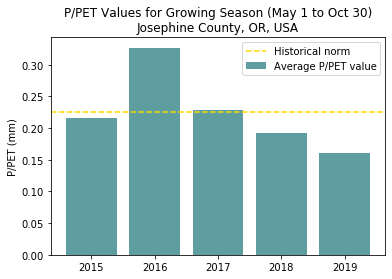

In [40]:
fig, ax = plt.subplots()

ax.set(title="P/PET Values for Growing Season (May 1 to Oct 30)\n" +
       "Josephine County, OR, USA",
      ylabel="P/PET (mm)")

ax.bar(master_gdf[1:].index.values, master_gdf[1:].inferred_ppet,
       color='cadetblue',
       label="Average P/PET value")

# Plot historical norm
ax.axhline(master_gdf[:1].inferred_ppet[0],
           linestyle="--",
           color="gold",
           label='Historical norm')

ax.legend()
plt.show()

In [ ]:
master_gdf[:]

In [ ]:
# Find droughted areas by size
master_gdf_crs_2019 = master_gdf.to_crs('EPSG:2019')
master_gdf_crs_2019['sqkm'] = master_gdf_crs_2019.geometry.area / 1000
master_gdf_crs_2019

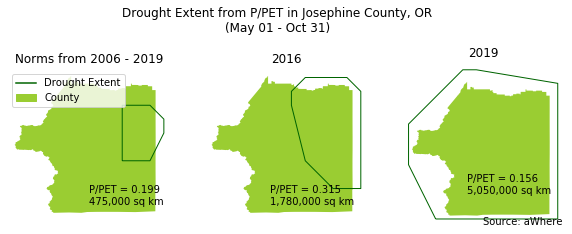

In [41]:
fig, (norms, y_2016, y_2019) = plt.subplots(1, 3, figsize=(10,4))

# Create title for entire plot set (3 plots)
fig.suptitle("Drought Extent from P/PET in Josephine County, OR\n"+
            "(May 01 - Oct 31)")

# For norms plot
norms.set_title("Norms from 2006 - 2019")
master_gdf[:1].plot(ax=norms, color="none", edgecolor='darkgreen', zorder=2)
josephine.plot(ax=norms, color='yellowgreen')
norms.text(0.5, 0.1, 'P/PET = 0.199\n475,000 sq km', transform=norms.transAxes)
norms.axis("off")

# For legend line
extent_line = mlines.Line2D([], [], color='darkgreen', label='Drought Extent')
county_patch = mpatches.Patch(color='yellowgreen', label='County')
norms.legend(handles=[extent_line, county_patch], loc=('upper left'))

# For 2016 plot
y_2016.set_title("2016")
master_gdf[2:3].plot(ax=y_2016, color="none", edgecolor='darkgreen', zorder=2)
josephine.plot(ax=y_2016, color='yellowgreen')
y_2016.text(0.4, 0.1, 'P/PET = 0.315\n1,780,000 sq km', transform=y_2016.transAxes)
y_2016.axis("off")

# For 2019 plot
y_2019.set_title("2019")
master_gdf[5:6].plot(ax=y_2019, color="none", edgecolor='darkgreen', zorder=2)
josephine.plot(ax=y_2019, color='yellowgreen')
y_2019.text(0.4, 0.2, 'P/PET = 0.156\n5,050,000 sq km', transform=y_2019.transAxes)
y_2019.text(0.5, 0.01, 'Source: aWhere', transform=y_2019.transAxes)
y_2019.axis("off")

plt.show()

In [ ]:
out_path = os.path.join(home, "Desktop", "drought-tracker", "data", "created")

master_gdf.to_file(os.path.join(out_path, "josephine_master.geojson"), driver='GeoJSON')

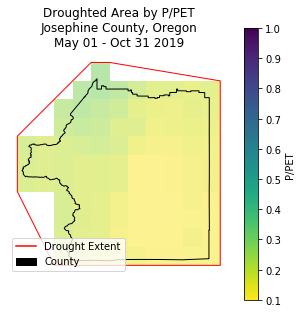

In [50]:
"""Create figure showing intermediate steps to illustrate workflow. 
For ease, show data from final iteration of loop."""

fig, ax = plt.subplots(figsize = (5,5))


ax.set(title="Droughted Area by P/PET\n" + 
       "Josephine County, Oregon\n" + 
       "May 01 - Oct 31 2019")

# Plot county
josephine.plot(color="none", 
               edgecolor="black", 
               ax=ax, 
               zorder=3)

# Plot convex hull for most recent year
master_gdf[-1:].plot(ax=ax, 
                     color="none", 
                     edgecolor="red", 
                     zorder=2)

# Plot last GDF from loop above for most recent year
year_gdf.plot(column='accum_ppet', 
              cmap='viridis_r', 
              ax=ax, 
              vmin=0.1, 
              vmax=1, 
              legend=True, 
              alpha=0.5,
              legend_kwds={'label': "P/PET"})

# Add legend items
extent_line = mlines.Line2D([], [], color='red', label='Drought Extent')
county_line = mpatches.Patch(color='black', label='County')
ax.legend(handles=[extent_line, county_line], loc=('lower left'))

# Turn off axis
ax.axis("off")

plt.show()

In [ ]:
raise ValueError("Old cells below")

In [ ]:
query_year = 2019
start_day = "06-01"
end_day = "10-30"
threshold = 0.5

# To hold info for all time periods: norms, last year, this year
all_time_periods_rows = []

# Calculate range of years (0 = norms)
years_range = [0, (query_year - 1), query_year]

# Create grid (does not change with each iteration)
josephine_grid, josephine = create_grid(study_area_path=path_to_josephine,
                                        buffer_distance=0.01,
                                        cell_size=0.08)


for year in years_range:

    # Get norms (when year = 0)
    if year == 0:

        year_gdf = get_norms(in_grid_gdf=josephine_grid,
                             start_d=start_day,
                             end_d=end_day,
                             drop_null=False)

        ppet_col_name = 'avg_accum_ppet'

        # Reclassify grid using binary thresholding (1 = over threshold)
        #year_gdf['ppet_under_thresh'] = year_gdf['avg_accum_ppet'].apply(lambda x: 1 if x <= threshold else 0)

    # Get actual/historical values
    else:

        start_d = f"{year}-{start_day}"

        end_d = f"{year}-{end_day}"

        year_gdf = get_vals(in_grid_gdf=josephine_grid,
                            start_d=start_d,
                            end_d=end_d,
                            drop_null=False)

        ppet_col_name = 'accum_ppet'

    year_gdf['ppet_under_thresh'] = year_gdf[ppet_col_name].apply(
        lambda x: 1 if x <= threshold else 0)

    # Generate convex hull
    year_convex_hull_gdf = to_convex_hull(year_gdf)

    # Proportional split ("2019" is CRS)
    avg_value = proportional_split(grid_gdf=year_gdf,
                                   hull_gdf=year_convex_hull_gdf,
                                   crs="2019",
                                   ppet_col_name=ppet_col_name)

    year_dict = {"year": year,
                 "inferred_ppet": avg_value,
                 "geometry": year_convex_hull_gdf[0]}

    all_time_periods_rows.append(year_dict)

gdf = gpd.GeoDataFrame(all_time_periods_rows, crs="EPSG:4236")

gdf.set_index(gdf.year, inplace=True)